# Mount Google Drive

In [3]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Set up the project structure

In [4]:
# Define paths
import os

# Path to your dataset in Google Drive
DATASET_PATH = '/content/drive/MyDrive/dataset'  # Update this path to your dataset location

# Path to save models
OUTPUT_DIR = '/content/drive/MyDrive/protein_ss_models'
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Set random seeds for reproducibility
import torch
import numpy as np
torch.manual_seed(0)
np.random.seed(0)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


## Verify the dataset

In [ ]:
import os
import pandas as pd
from collections import defaultdict

def check_dssp_file(file_path):
    """Check if a DSSP file can be properly loaded and contains secondary structure"""
    try:
        with open(file_path, 'r') as f:
            lines = f.readlines()

        # Skip header line (starting with '>') and get the secondary structure sequence
        ss_sequence = ""
        for line in lines:
            if line.startswith('>'):
                continue
            ss_sequence += line.strip()

        # Validate that we only have H, E, C characters
        invalid_chars = []
        for char in ss_sequence:
            if char not in ['H', 'E', 'C']:
                invalid_chars.append(char)

        if invalid_chars:
            return f"Invalid characters: {', '.join(set(invalid_chars))}", len(ss_sequence)

        if not ss_sequence:
            return "Empty secondary structure", 0

        return "OK", len(ss_sequence)

    except Exception as e:
        return f"Error: {e}", 0

def check_fasta_file(file_path):
    """Check if a FASTA file can be properly loaded and contains a sequence"""
    try:
        with open(file_path, 'r') as f:
            lines = f.readlines()

        # Skip header line and join all sequence lines
        sequence = ""
        for line in lines:
            if line.startswith('>'):
                continue
            sequence += line.strip()

        if not sequence:
            return "Empty sequence", 0

        return "OK", len(sequence)

    except Exception as e:
        return f"Error: {e}", 0

def check_pssm_file(file_path):
    """Check if a PSSM file can be properly loaded"""
    try:
        data = pd.read_csv(file_path)
        return "OK", data.shape[0]
    except Exception as e:
        return f"Error: {e}", 0

def main(data_dir):

    dssp_dir = os.path.join(data_dir, 'dssp')
    fasta_dir = os.path.join(data_dir, 'fasta')
    pssm_dir = os.path.join(data_dir, 'pssm')

    # Check if directories exist
    for directory in [dssp_dir, fasta_dir, pssm_dir]:
        if not os.path.exists(directory):
            print(f"Error: Directory {directory} does not exist")
            return

    # Get all file IDs
    file_ids = []
    for filename in os.listdir(dssp_dir):
        if filename.endswith('.dssp'):
            # Remove only the .dssp extension, keep the rest of the filename
            file_id = filename[:-5]  # Remove '.dssp'
            file_ids.append(file_id)

    print(f"Found {len(file_ids)} DSSP files")

    # Check each file
    results = []
    for file_id in file_ids:
        dssp_path = os.path.join(dssp_dir, f"{file_id}.dssp")
        fasta_path = os.path.join(fasta_dir, f"{file_id}.fasta")
        pssm_path = os.path.join(pssm_dir, f"{file_id}.csv")

        dssp_result, dssp_len = check_dssp_file(dssp_path)

        fasta_exists = os.path.exists(fasta_path)
        fasta_result = "Not found"
        fasta_len = 0
        if fasta_exists:
            fasta_result, fasta_len = check_fasta_file(fasta_path)

        pssm_exists = os.path.exists(pssm_path)
        pssm_result = "Not found"
        pssm_len = 0
        if pssm_exists:
            pssm_result, pssm_len = check_pssm_file(pssm_path)

        results.append({
            'file_id': file_id,
            'dssp_result': dssp_result if isinstance(dssp_result, str) and dssp_result.startswith('Error') else 'OK',
            'dssp_len': dssp_len,
            'fasta_exists': fasta_exists,
            'fasta_result': fasta_result if isinstance(fasta_result, str) and fasta_result.startswith('Error') else 'OK',
            'fasta_len': fasta_len,
            'pssm_exists': pssm_exists,
            'pssm_result': pssm_result if isinstance(pssm_result, str) and pssm_result.startswith('Error') else 'OK',
            'pssm_len': pssm_len,
            'fasta_dssp_match': fasta_len == dssp_len,
            'pssm_dssp_match': pssm_len == dssp_len
        })

    # Analyze results
    issues = defaultdict(list)
    for result in results:
        if result['dssp_result'] != 'OK':
            issues['dssp_error'].append(result['file_id'])
        if result['dssp_len'] == 0:
            issues['empty_dssp'].append(result['file_id'])
        if not result['fasta_exists']:
            issues['missing_fasta'].append(result['file_id'])
        elif result['fasta_result'] != 'OK':
            issues['fasta_error'].append(result['file_id'])
        elif result['fasta_len'] == 0:
            issues['empty_fasta'].append(result['file_id'])
        if not result['pssm_exists']:
            issues['missing_pssm'].append(result['file_id'])
        elif result['pssm_result'] != 'OK':
            issues['pssm_error'].append(result['file_id'])
        elif result['pssm_len'] == 0:
            issues['empty_pssm'].append(result['file_id'])
        if result['fasta_exists'] and result['fasta_result'] == 'OK' and not result['fasta_dssp_match']:
            issues['fasta_dssp_mismatch'].append((result['file_id'], result['fasta_len'], result['dssp_len']))
        if result['pssm_exists'] and result['pssm_result'] == 'OK' and not result['pssm_dssp_match']:
            issues['pssm_dssp_mismatch'].append((result['file_id'], result['pssm_len'], result['dssp_len']))

    # Print summary
    print("\nDataset Summary:")
    print(f"Total files: {len(file_ids)}")
    print(f"Files with DSSP errors: {len(issues['dssp_error'])}")
    print(f"Files with empty DSSP: {len(issues['empty_dssp'])}")
    print(f"Files missing FASTA: {len(issues['missing_fasta'])}")
    print(f"Files with FASTA errors: {len(issues['fasta_error'])}")
    print(f"Files with empty FASTA: {len(issues['empty_fasta'])}")
    print(f"Files missing PSSM: {len(issues['missing_pssm'])}")
    print(f"Files with PSSM errors: {len(issues['pssm_error'])}")
    print(f"Files with empty PSSM: {len(issues['empty_pssm'])}")
    print(f"Files with FASTA-DSSP length mismatch: {len(issues['fasta_dssp_mismatch'])}")
    print(f"Files with PSSM-DSSP length mismatch: {len(issues['pssm_dssp_mismatch'])}")

    # Print detailed issues
    if issues['fasta_dssp_mismatch']:
        print("\nFASTA-DSSP length mismatches:")
        for file_id, fasta_len, dssp_len in issues['fasta_dssp_mismatch'][:10]:  # Show first 10
            print(f"  {file_id}: FASTA={fasta_len}, DSSP={dssp_len}")
        if len(issues['fasta_dssp_mismatch']) > 10:
            print(f"  ... and {len(issues['fasta_dssp_mismatch']) - 10} more")

    if issues['pssm_dssp_mismatch']:
        print("\nPSSM-DSSP length mismatches:")
        for file_id, pssm_len, dssp_len in issues['pssm_dssp_mismatch'][:10]:  # Show first 10
            print(f"  {file_id}: PSSM={pssm_len}, DSSP={dssp_len}")
        if len(issues['pssm_dssp_mismatch']) > 10:
            print(f"  ... and {len(issues['pssm_dssp_mismatch']) - 10} more")

    # Save detailed results to CSV
    df = pd.DataFrame(results)
    df.to_csv('dataset_check_results.csv', index=False)
    print("\nDetailed results saved to dataset_check_results.csv")

if __name__ == '__main__':
    main('/content/drive/MyDrive/dataset/')

Found 1200 DSSP files

Dataset Summary:
Total files: 1200
Files with DSSP errors: 0
Files with empty DSSP: 0
Files missing FASTA: 0
Files with FASTA errors: 0
Files with empty FASTA: 0
Files missing PSSM: 0
Files with PSSM errors: 0
Files with empty PSSM: 0
Files with FASTA-DSSP length mismatch: 0
Files with PSSM-DSSP length mismatch: 2

PSSM-DSSP length mismatches:
  d2ciwa1: PSSM=298, DSSP=299
  d3u81a_: PSSM=218, DSSP=219

Detailed results saved to dataset_check_results.csv


# Loading Data

In [5]:
#%%writefile /content/protein_ss_prediction/src/data_loader.py
import os
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split, StratifiedKFold
import torch
import pickle
import time
from torch.nn.utils.rnn import pad_sequence

class ProteinDataset(Dataset):
    def __init__(self, sequences, labels, input_type='fasta'):
        """
        Initialize the dataset
        Args:
            sequences: List of sequences (either FASTA, PSSM, or combined)
            labels: List of secondary structure labels
            input_type: 'fasta', 'pssm', or 'combined'
        """
        self.sequences = sequences
        self.labels = labels
        self.input_type = input_type

        # Amino acid to index mapping for FASTA sequences
        self.aa_to_idx = {
            'A': 0, 'C': 1, 'D': 2, 'E': 3, 'F': 4, 'G': 5, 'H': 6, 'I': 7,
            'K': 8, 'L': 9, 'M': 10, 'N': 11, 'P': 12, 'Q': 13, 'R': 14,
            'S': 15, 'T': 16, 'V': 17, 'W': 18, 'Y': 19, 'X': 20  # X for unknown
        }

        # Secondary structure to index mapping
        self.ss_to_idx = {'H': 0, 'E': 1, 'C': 2}

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        sequence = self.sequences[idx]
        label = self.labels[idx]

        if self.input_type == 'fasta':
            # One-hot encode the sequence
            encoded = np.zeros((len(sequence), 21))  # 20 amino acids + unknown
            for i, aa in enumerate(sequence):
                if aa in self.aa_to_idx:
                    encoded[i, self.aa_to_idx[aa]] = 1
                else:
                    encoded[i, self.aa_to_idx['X']] = 1  # Unknown amino acid
        elif self.input_type == 'pssm':
            # Min-max normalize PSSM
            encoded = sequence.copy()
            # Normalize each row to [0, 1]
            row_min = encoded.min(axis=1, keepdims=True)
            row_max = encoded.max(axis=1, keepdims=True)
            row_range = row_max - row_min
            row_range[row_range == 0] = 1  # Avoid division by zero
            encoded = (encoded - row_min) / row_range
        else:  # combined
            # Extract FASTA and PSSM
            fasta_seq, pssm_seq = sequence

            # One-hot encode FASTA
            fasta_encoded = np.zeros((len(fasta_seq), 21))
            for i, aa in enumerate(fasta_seq):
                if aa in self.aa_to_idx:
                    fasta_encoded[i, self.aa_to_idx[aa]] = 1
                else:
                    fasta_encoded[i, self.aa_to_idx['X']] = 1

            # Min-max normalize PSSM
            pssm_encoded = pssm_seq.copy()
            row_min = pssm_encoded.min(axis=1, keepdims=True)
            row_max = pssm_encoded.max(axis=1, keepdims=True)
            row_range = row_max - row_min
            row_range[row_range == 0] = 1
            pssm_encoded = (pssm_encoded - row_min) / row_range

            # Concatenate FASTA and PSSM
            encoded = np.concatenate([fasta_encoded, pssm_encoded], axis=1)

        # Convert label to index
        label_idx = [self.ss_to_idx[ss] for ss in label]

        return torch.FloatTensor(encoded), torch.LongTensor(label_idx)

# Custom collate function to handle variable-length sequences
def collate_fn(batch):
    """
    Custom collate function for variable-length sequences
    Args:
        batch: List of (sequence, label) tuples
    Returns:
        Padded sequences, padded labels, sequence lengths
    """
    # Sort batch by sequence length (descending)
    batch.sort(key=lambda x: x[0].size(0), reverse=True)

    # Get sequence lengths
    lengths = [x[0].size(0) for x in batch]
    max_length = lengths[0]

    # Get batch size and feature dimension
    batch_size = len(batch)
    feature_dim = batch[0][0].size(1)

    # Create padded tensors
    padded_seqs = torch.zeros(batch_size, max_length, feature_dim)
    padded_labels = torch.zeros(batch_size, max_length, dtype=torch.long)

    # Fill padded tensors
    for i, (seq, label) in enumerate(batch):
        seq_len = seq.size(0)
        padded_seqs[i, :seq_len, :] = seq
        padded_labels[i, :seq_len] = label

    # Create length tensor
    lengths = torch.LongTensor(lengths)

    return padded_seqs, padded_labels, lengths

def load_dssp_file(file_path):
    """
    Load secondary structure from DSSP file

    In this dataset, DSSP files are in a simplified FASTA-like format:
    - First line is a header starting with '>'
    - Second line contains the secondary structure sequence using H, E, C encoding

    H: Helix
    E: Strand
    C: Coil
    """
    try:
        with open(file_path, 'r') as f:
            lines = f.readlines()

        # Skip header line (starting with '>') and get the secondary structure sequence
        ss_sequence = ""
        for line in lines:
            if line.startswith('>'):
                continue
            ss_sequence += line.strip()

        # Validate that we only have H, E, C characters
        for char in ss_sequence:
            if char not in ['H', 'E', 'C']:
                print(f"Warning: Unexpected character '{char}' in DSSP file {file_path}")

        if not ss_sequence:
            print(f"Warning: No secondary structure found in {file_path}")

        return ss_sequence

    except Exception as e:
        print(f"Error loading DSSP file {file_path}: {e}")
        return ""

def load_fasta_file(file_path):
    """Load sequence from FASTA file"""
    try:
        with open(file_path, 'r') as f:
            lines = f.readlines()

        # Skip header line and join all sequence lines
        sequence = ""
        for line in lines:
            if line.startswith('>'):
                continue
            sequence += line.strip()

        return sequence

    except Exception as e:
        print(f"Error loading FASTA file {file_path}: {e}")
        return ""

def load_pssm_file(file_path):
    """Load PSSM from CSV file"""
    try:
        return pd.read_csv(file_path).values
    except Exception as e:
        print(f"Error loading PSSM file {file_path}: {e}")
        return np.array([])

def save_processed_data(data_dict, output_path):
    """
    Save processed data to a pickle file
    Args:
        data_dict: Dictionary containing processed data
        output_path: Path to save the pickle file
    """
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    with open(output_path, 'wb') as f:
        pickle.dump(data_dict, f)
    print(f"Processed data saved to {output_path}")

def load_processed_data(input_path):
    """
    Load processed data from a pickle file
    Args:
        input_path: Path to the pickle file
    Returns:
        Dictionary containing processed data
    """
    with open(input_path, 'rb') as f:
        data_dict = pickle.load(f)
    print(f"Processed data loaded from {input_path}")
    return data_dict

def prepare_dataset(data_dir, input_type='fasta', random_seed=0, batch_size=32, pssm_tolerance=1,
                   cache_dir=None, use_cache=True, force_reload=False, fold_idx=None, num_folds=5):
    """
    Prepare the dataset by loading all files and splitting into train/val/test
    Args:
        data_dir: Root directory containing dssp/, fasta/, and pssm/ subdirectories
        input_type: 'fasta', 'pssm', or 'combined'
        random_seed: Random seed for reproducibility
        batch_size: Batch size for data loaders
        pssm_tolerance: Tolerance for PSSM-DSSP length mismatch (only for PSSM input)
        cache_dir: Directory to save/load processed data
        use_cache: Whether to use cached data if available
        force_reload: Whether to force reload data even if cache exists
        fold_idx: Index of the fold to use for validation (if None, use train/val/test split)
        num_folds: Number of folds for cross-validation
    Returns:
        train_loader, val_loader, test_loader
    """
    # Set up cache path
    if cache_dir is None:
        cache_dir = os.path.join(data_dir, 'cache')
    os.makedirs(cache_dir, exist_ok=True)

    cache_file = os.path.join(cache_dir, f"processed_data_{input_type}_seed{random_seed}_tol{pssm_tolerance}.pkl")

    # Check if cached data exists and should be used
    if use_cache and os.path.exists(cache_file) and not force_reload:
        print(f"Loading cached processed data from {cache_file}")
        data_dict = load_processed_data(cache_file)

        # Create datasets from cached data
        if fold_idx is not None and 'fold_indices' in data_dict:
            # Use cross-validation folds
            fold_indices = data_dict['fold_indices']
            if fold_idx >= len(fold_indices):
                raise ValueError(f"Fold index {fold_idx} is out of range (0-{len(fold_indices)-1})")

            # Get train and validation indices for this fold
            val_idx = fold_indices[fold_idx]
            train_idx = []
            for i in range(len(fold_indices)):
                if i != fold_idx:
                    train_idx.extend(fold_indices[i])

            # Get test indices (20% of data)
            test_idx = data_dict['test_idx']

            # Create datasets
            train_sequences = [data_dict['sequences'][i] for i in train_idx]
            train_labels = [data_dict['labels'][i] for i in train_idx]
            val_sequences = [data_dict['sequences'][i] for i in val_idx]
            val_labels = [data_dict['labels'][i] for i in val_idx]
            test_sequences = [data_dict['sequences'][i] for i in test_idx]
            test_labels = [data_dict['labels'][i] for i in test_idx]
        else:
            # Use train/val/test split
            train_sequences = data_dict['train_sequences']
            train_labels = data_dict['train_labels']
            val_sequences = data_dict['val_sequences']
            val_labels = data_dict['val_labels']
            test_sequences = data_dict['test_sequences']
            test_labels = data_dict['test_labels']

        # Create datasets
        train_dataset = ProteinDataset(train_sequences, train_labels, input_type)
        val_dataset = ProteinDataset(val_sequences, val_labels, input_type)
        test_dataset = ProteinDataset(test_sequences, test_labels, input_type)

        # Create data loaders with custom collate function
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

        print(f"Train: {len(train_dataset)}, Validation: {len(val_dataset)}, Test: {len(test_dataset)}")

        return train_loader, val_loader, test_loader

    # If no cache or force reload, process the data
    print(f"Processing data from {data_dir}")
    start_time = time.time()

    # Get all file IDs
    dssp_dir = os.path.join(data_dir, 'dssp')

    # Fix file ID parsing to preserve the full identifier
    file_ids = []
    for filename in os.listdir(dssp_dir):
        if filename.endswith('.dssp'):
            # Remove only the .dssp extension, keep the rest of the filename
            file_id = filename[:-5]  # Remove '.dssp'
            file_ids.append(file_id)

    print(f"Found {len(file_ids)} DSSP files")

    # Load all data
    sequences = []
    labels = []

    # Track files that were successfully loaded
    valid_files = []
    skipped_files = []
    adjusted_files = []

    for file_id in file_ids:
        try:
            # Load label
            dssp_path = os.path.join(dssp_dir, f"{file_id}.dssp")
            label = load_dssp_file(dssp_path)

            if not label:
                print(f"Skipping {file_id}: Empty secondary structure")
                skipped_files.append((file_id, "empty_label"))
                continue

            # Load sequence based on input type
            if input_type == 'fasta' or input_type == 'combined':
                fasta_path = os.path.join(data_dir, 'fasta', f"{file_id}.fasta")
                if not os.path.exists(fasta_path):
                    print(f"Skipping {file_id}: FASTA file not found")
                    skipped_files.append((file_id, "fasta_not_found"))
                    continue
                fasta_sequence = load_fasta_file(fasta_path)
                if not fasta_sequence:
                    print(f"Skipping {file_id}: Empty FASTA sequence")
                    skipped_files.append((file_id, "empty_sequence"))
                    continue

                # Ensure sequence and label have the same length
                if len(fasta_sequence) != len(label):
                    print(f"Warning: Length mismatch for {file_id}: seq={len(fasta_sequence)}, label={len(label)}")
                    print(f"Sequence start: {fasta_sequence[:10]}")
                    print(f"Label start: {label[:10]}")
                    skipped_files.append((file_id, "length_mismatch"))
                    continue

            if input_type == 'pssm' or input_type == 'combined':
                pssm_path = os.path.join(data_dir, 'pssm', f"{file_id}.csv")
                if not os.path.exists(pssm_path):
                    print(f"Skipping {file_id}: PSSM file not found")
                    skipped_files.append((file_id, "pssm_not_found"))
                    continue
                pssm_sequence = load_pssm_file(pssm_path)
                if pssm_sequence.size == 0:
                    print(f"Skipping {file_id}: Empty PSSM matrix")
                    skipped_files.append((file_id, "empty_pssm"))
                    continue

                # Handle PSSM-DSSP length mismatch with tolerance
                length_diff = abs(pssm_sequence.shape[0] - len(label))
                if length_diff > 0:
                    if length_diff <= pssm_tolerance:
                        # Adjust the longer one to match the shorter one
                        if pssm_sequence.shape[0] > len(label):
                            # Trim PSSM to match DSSP length
                            pssm_sequence = pssm_sequence[:len(label)]
                            print(f"Adjusted PSSM length for {file_id}: trimmed {length_diff} residue(s)")
                        else:
                            # Trim DSSP to match PSSM length
                            label = label[:pssm_sequence.shape[0]]
                            if input_type == 'combined':
                                # Also trim FASTA to match
                                fasta_sequence = fasta_sequence[:pssm_sequence.shape[0]]
                            print(f"Adjusted DSSP length for {file_id}: trimmed {length_diff} residue(s)")
                        adjusted_files.append((file_id, length_diff))
                    else:
                        print(f"Warning: Length mismatch for {file_id}: seq={pssm_sequence.shape[0]}, label={len(label)}")
                        skipped_files.append((file_id, "length_mismatch"))
                        continue

            # Store sequence and label based on input type
            if input_type == 'fasta':
                sequence = fasta_sequence
            elif input_type == 'pssm':
                sequence = pssm_sequence
            else:  # combined
                sequence = (fasta_sequence, pssm_sequence)

            sequences.append(sequence)
            labels.append(label)
            valid_files.append(file_id)
        except Exception as e:
            print(f"Error processing {file_id}: {e}")
            skipped_files.append((file_id, "error"))

    print(f"Successfully loaded {len(valid_files)} files out of {len(file_ids)}")

    # Analyze skipped files
    if skipped_files:
        reasons = {}
        for _, reason in skipped_files:
            reasons[reason] = reasons.get(reason, 0) + 1
        print("Skipped files by reason:")
        for reason, count in reasons.items():
            print(f"  {reason}: {count}")

    # Report adjusted files
    if adjusted_files:
        print(f"Adjusted {len(adjusted_files)} files for length mismatches within tolerance:")
        for file_id, diff in adjusted_files[:5]:  # Show first 5
            print(f"  {file_id}: adjusted by {diff} residue(s)")
        if len(adjusted_files) > 5:
            print(f"  ... and {len(adjusted_files) - 5} more")

    if not valid_files:
        raise ValueError("No valid files were loaded. Check your dataset paths and file formats.")

    # Split dataset
    if fold_idx is not None:
        # Use stratified k-fold cross-validation
        # Create a simple label representation for stratification
        # (use the most common secondary structure in each sequence)
        stratify_labels = []
        for label in labels:
            h_count = label.count('H')
            e_count = label.count('E')
            c_count = label.count('C')
            if h_count >= e_count and h_count >= c_count:
                stratify_labels.append(0)  # H dominant
            elif e_count >= h_count and e_count >= c_count:
                stratify_labels.append(1)  # E dominant
            else:
                stratify_labels.append(2)  # C dominant

        # Create folds
        skf = StratifiedKFold(n_splits=num_folds, random_state=random_seed, shuffle=True)
        fold_indices = []
        for _, val_idx in skf.split(sequences, stratify_labels):
            fold_indices.append(val_idx.tolist())

        # Split into train/test first (80/20)
        train_val_idx, test_idx = train_test_split(
            range(len(sequences)), test_size=0.2, random_state=random_seed,
            stratify=stratify_labels
        )

        # Use the specified fold for validation
        val_idx = [idx for idx in fold_indices[fold_idx] if idx in train_val_idx]
        train_idx = [idx for idx in train_val_idx if idx not in val_idx]

        print(f"Using fold {fold_idx} for validation")
        print(f"Train: {len(train_idx)}, Validation: {len(val_idx)}, Test: {len(test_idx)}")

        # Prepare data
        train_sequences = [sequences[i] for i in train_idx]
        train_labels = [labels[i] for i in train_idx]
        val_sequences = [sequences[i] for i in val_idx]
        val_labels = [labels[i] for i in val_idx]
        test_sequences = [sequences[i] for i in test_idx]
        test_labels = [labels[i] for i in test_idx]

        # Save fold indices for future use
        data_dict = {
            'sequences': sequences,
            'labels': labels,
            'fold_indices': fold_indices,
            'test_idx': test_idx,
            'train_sequences': train_sequences,
            'train_labels': train_labels,
            'val_sequences': val_sequences,
            'val_labels': val_labels,
            'test_sequences': test_sequences,
            'test_labels': test_labels,
            'input_type': input_type,
            'random_seed': random_seed,
            'pssm_tolerance': pssm_tolerance,
            'valid_files': valid_files,
            'skipped_files': skipped_files,
            'adjusted_files': adjusted_files
        }
    else:
        # Use regular train/val/test split
        train_idx, temp_idx = train_test_split(
            range(len(sequences)), test_size=0.3, random_state=random_seed
        )
        val_idx, test_idx = train_test_split(
            temp_idx, test_size=0.5, random_state=random_seed
        )

        print(f"Train: {len(train_idx)}, Validation: {len(val_idx)}, Test: {len(test_idx)}")

        # Prepare data for caching
        train_sequences = [sequences[i] for i in train_idx]
        train_labels = [labels[i] for i in train_idx]
        val_sequences = [sequences[i] for i in val_idx]
        val_labels = [labels[i] for i in val_idx]
        test_sequences = [sequences[i] for i in test_idx]
        test_labels = [labels[i] for i in test_idx]

        # Save processed data to cache
        data_dict = {
            'train_sequences': train_sequences,
            'train_labels': train_labels,
            'val_sequences': val_sequences,
            'val_labels': val_labels,
            'test_sequences': test_sequences,
            'test_labels': test_labels,
            'input_type': input_type,
            'random_seed': random_seed,
            'pssm_tolerance': pssm_tolerance,
            'valid_files': valid_files,
            'skipped_files': skipped_files,
            'adjusted_files': adjusted_files
        }

    # Save processed data to cache
    if use_cache:
        save_processed_data(data_dict, cache_file)

    # Create datasets
    train_dataset = ProteinDataset(train_sequences, train_labels, input_type)
    val_dataset = ProteinDataset(val_sequences, val_labels, input_type)
    test_dataset = ProteinDataset(test_sequences, test_labels, input_type)

    # Create data loaders with custom collate function
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

    end_time = time.time()
    print(f"Data processing completed in {end_time - start_time:.2f} seconds")

    return train_loader, val_loader, test_loader

def data_augmentation(sequences, labels, window_size=15, stride=5):
    """
    Apply sliding window data augmentation
    Args:
        sequences: List of sequences
        labels: List of labels
        window_size: Size of the sliding window
        stride: Stride of the sliding window
    Returns:
        Augmented sequences and labels
    """
    aug_sequences = []
    aug_labels = []

    for seq, label in zip(sequences, labels):
        # Skip if sequence is shorter than window size
        if len(seq) <= window_size:
            aug_sequences.append(seq)
            aug_labels.append(label)
            continue

        # Apply sliding window
        for i in range(0, len(seq) - window_size + 1, stride):
            if isinstance(seq, tuple):  # Combined input
                fasta_seq, pssm_seq = seq
                aug_seq = (fasta_seq[i:i+window_size], pssm_seq[i:i+window_size])
            else:
                aug_seq = seq[i:i+window_size]
            aug_label = label[i:i+window_size]

            aug_sequences.append(aug_seq)
            aug_labels.append(aug_label)

    return aug_sequences, aug_labels

# Building Models

In [6]:
#%%writefile /content/protein_ss_prediction/src/model.py
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, matthews_corrcoef
import matplotlib.pyplot as plt
import seaborn as sns
import random

def set_seed(seed=0):
    """Set random seed for reproducibility"""
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

class ChannelAttention(nn.Module):
    """
    Channel Attention module (SENet-style)
    """
    def __init__(self, channels, reduction=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.max_pool = nn.AdaptiveMaxPool1d(1)

        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels, bias=False)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        b, c, _ = x.size()

        # Average pooling
        avg_out = self.fc(self.avg_pool(x).view(b, c))

        # Max pooling
        max_out = self.fc(self.max_pool(x).view(b, c))

        # Combine and apply sigmoid
        out = self.sigmoid(avg_out + max_out).view(b, c, 1)

        return x * out

class DilatedConvBlock(nn.Module):
    """
    Dilated Convolution Block for multi-scale feature extraction
    """
    def __init__(self, in_channels=256, out_channels=256, dilation=1, dropout=0.3):
        super(DilatedConvBlock, self).__init__()
        self.conv = nn.Conv1d(
            in_channels,
            out_channels,
            kernel_size=3,
            padding=dilation,
            dilation=dilation
        )
        self.bn = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.dropout(self.relu(self.bn(self.conv(x))))

class MSBTCN(nn.Module):
    """
    Multi-Scale Bidirectional Temporal Convolutional Network
    """
    def __init__(self, in_channels, out_channels=256):
        super(MSBTCN, self).__init__()

        # 1x1 convolution for dimension matching in first residual connection
        self.dim_match_conv = nn.Conv1d(in_channels, out_channels, kernel_size=1)

        # Multiple dilated convolutions with different dilation rates
        self.dilated_convs = nn.ModuleList([
            DilatedConvBlock(in_channels, out_channels, dilation=1),
            DilatedConvBlock(out_channels, out_channels, dilation=2),
            DilatedConvBlock(out_channels, out_channels, dilation=4),
            DilatedConvBlock(out_channels, out_channels, dilation=8)
        ])

        # Channel attention
        self.attention = ChannelAttention(out_channels)

        # Final 1x1 convolution
        self.conv_1x1 = nn.Conv1d(out_channels, out_channels, kernel_size=1)

    def forward(self, x):
        # Apply dilated convolutions
        out = x
        for i, conv in enumerate(self.dilated_convs):
            if i == 0:
                # For the first convolution, use dimension matching conv for residual
                residual = self.dim_match_conv(out)
                out = conv(out) + residual
            else:
                # For subsequent convolutions, dimensions already match
                out = conv(out) + out  # Residual connection

        # Apply channel attention
        out = self.attention(out)

        # Apply final 1x1 convolution
        out = self.conv_1x1(out)

        return out

class PSSPModel(nn.Module):
    """
    Protein Secondary Structure Prediction Model
    Hybrid CNN-BiLSTM-MSBTCN architecture
    """
    def __init__(self, input_dim=41, hidden_dim=256, output_dim=3, num_layers=2, dropout=0.3):
        """
        Initialize the model
        Args:
            input_dim: Input dimension (41 for combined FASTA+PSSM, 20 for FASTA only or PSSM only)
            hidden_dim: Hidden dimension
            output_dim: Output dimension (3 for H, E, C)
            num_layers: Number of LSTM layers
            dropout: Dropout probability
        """
        super(PSSPModel, self).__init__()

        # Local feature extractor (CNN)
        self.conv = nn.Sequential(
            nn.Conv1d(input_dim, 64, kernel_size=5, padding=2),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

        # Global context (BiLSTM)
        self.bilstm = nn.LSTM(
            128, hidden_dim, num_layers=num_layers,
            bidirectional=True, batch_first=True, dropout=dropout if num_layers > 1 else 0
        )

        # Multi-scale features (MSBTCN)
        self.msbtcn = MSBTCN(hidden_dim * 2, hidden_dim)

        # Output layer
        self.fc = nn.Linear(hidden_dim, output_dim)

        # Dropout
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, lengths):
        """
        Forward pass
        Args:
            x: Input tensor of shape (batch_size, seq_len, input_dim)
            lengths: Sequence lengths tensor of shape (batch_size)
        Returns:
            Output tensor of shape (batch_size, seq_len, output_dim)
        """
        batch_size, seq_len, _ = x.size()

        # Transpose for CNN
        x = x.transpose(1, 2)  # (batch_size, input_dim, seq_len)

        # Apply CNN
        x = self.conv(x)  # (batch_size, 128, seq_len)

        # Transpose back for LSTM
        x = x.transpose(1, 2)  # (batch_size, seq_len, 128)

        # Pack padded sequence for efficient computation
        packed_x = nn.utils.rnn.pack_padded_sequence(x, lengths.cpu(), batch_first=True, enforce_sorted=True)

        # BiLSTM forward pass
        packed_output, _ = self.bilstm(packed_x)

        # Unpack the sequence
        output, _ = nn.utils.rnn.pad_packed_sequence(packed_output, batch_first=True)

        # Transpose for MSBTCN
        output = output.transpose(1, 2)  # (batch_size, hidden_dim*2, seq_len)

        # Apply MSBTCN
        output = self.msbtcn(output)  # (batch_size, hidden_dim, seq_len)

        # Transpose back
        output = output.transpose(1, 2)  # (batch_size, seq_len, hidden_dim)

        # Apply dropout
        output = self.dropout(output)

        # Apply fully connected layer
        output = self.fc(output)  # (batch_size, seq_len, output_dim)

        return output

def calculate_class_weights(labels, num_classes=3):
    """
    Calculate class weights for imbalanced dataset
    Args:
        labels: List of labels or flattened label tensor
        num_classes: Number of classes
    Returns:
        Class weights tensor
    """
    # Check if labels is already a flat list
    if isinstance(labels, list) and all(isinstance(x, int) for x in labels):
        flat_labels = labels
    else:
        # Flatten labels if it's a list of sequences
        flat_labels = []
        for label_seq in labels:
            if isinstance(label_seq, (list, tuple)) or hasattr(label_seq, '__iter__'):
                flat_labels.extend(label_seq)
            else:
                flat_labels.append(label_seq)

    # Count occurrences of each class
    class_counts = np.zeros(num_classes)
    for label in flat_labels:
        if label < num_classes:  # Ignore padding
            class_counts[label] += 1

    # Calculate weights (inverse of frequency)
    total = np.sum(class_counts)
    class_weights = total / (class_counts * num_classes)

    # Convert to tensor
    return torch.FloatTensor(class_weights)



# Create training and evaluation functions

In [16]:
def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=100, patience=10, scheduler=None):
    """
    Train the model
    Args:
        model: Model to train
        train_loader: Training data loader
        val_loader: Validation data loader
        criterion: Loss function
        optimizer: Optimizer
        device: Device to train on
        num_epochs: Number of epochs
        patience: Early stopping patience
        scheduler: Learning rate scheduler
    Returns:
        Training history, best model state
    """
    model.to(device)

    # Initialize history
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': [],
        'train_f1': [],
        'val_f1': [],
        'train_mcc': [],
        'val_mcc': []
    }

    # Initialize early stopping variables
    best_val_loss = float('inf')
    best_model_state = None
    patience_counter = 0

    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0
        all_train_preds = []
        all_train_targets = []

        for batch_idx, (data, target, lengths) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            lengths = lengths.to(device)

            # Forward pass
            optimizer.zero_grad()
            output = model(data, lengths)

            # Reshape for loss calculation
            batch_size, seq_len, num_classes = output.shape
            output_flat = output.view(-1, num_classes)
            target_flat = target.view(-1)

            # Calculate loss (ignore padding)
            mask = target_flat != 0  # Assuming 0 is the padding index
            loss = criterion(output_flat, target_flat)

            # Backward pass
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            optimizer.step()

            # Calculate accuracy
            _, predicted = torch.max(output_flat.data, 1)
            train_correct += (predicted[mask] == target_flat[mask]).sum().item()
            train_total += mask.sum().item()

            # Store predictions and targets for metrics
            all_train_preds.extend(predicted[mask].cpu().numpy())
            all_train_targets.extend(target_flat[mask].cpu().numpy())

            train_loss += loss.item()

            # Print progress
            if (batch_idx + 1) % 10 == 0:
                print(f'Epoch: {epoch+1}/{num_epochs}, Batch: {batch_idx+1}/{len(train_loader)}, Loss: {loss.item():.4f}')

        train_loss /= len(train_loader)
        train_acc = train_correct / train_total if train_total > 0 else 0
        train_f1 = f1_score(all_train_targets, all_train_preds, average='macro')
        train_mcc = matthews_corrcoef(all_train_targets, all_train_preds)

        # Validation
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0
        all_val_preds = []
        all_val_targets = []

        with torch.no_grad():
            for data, target, lengths in val_loader:
                data, target = data.to(device), target.to(device)
                lengths = lengths.to(device)

                # Forward pass
                output = model(data, lengths)

                # Reshape for loss calculation
                batch_size, seq_len, num_classes = output.shape
                output_flat = output.view(-1, num_classes)
                target_flat = target.view(-1)

                # Calculate loss
                mask = target_flat != 0  # Assuming 0 is the padding index
                loss = criterion(output_flat, target_flat)
                val_loss += loss.item()

                # Calculate accuracy
                _, predicted = torch.max(output_flat.data, 1)
                val_correct += (predicted[mask] == target_flat[mask]).sum().item()
                val_total += mask.sum().item()

                # Store predictions and targets for metrics
                all_val_preds.extend(predicted[mask].cpu().numpy())
                all_val_targets.extend(target_flat[mask].cpu().numpy())

        val_loss /= len(val_loader)
        val_acc = val_correct / val_total if val_total > 0 else 0
        val_f1 = f1_score(all_val_targets, all_val_preds, average='macro')
        val_mcc = matthews_corrcoef(all_val_targets, all_val_preds)

        # Update learning rate
        if scheduler is not None:
            scheduler.step()

        # Update history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        history['train_f1'].append(train_f1)
        history['val_f1'].append(val_f1)
        history['train_mcc'].append(train_mcc)
        history['val_mcc'].append(val_mcc)

        print(f'Epoch: {epoch+1}/{num_epochs}')
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Train F1: {train_f1:.4f}, Train MCC: {train_mcc:.4f}')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val F1: {val_f1:.4f}, Val MCC: {val_mcc:.4f}')

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f'Early stopping at epoch {epoch+1}')
                break

    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    return history, best_model_state

def evaluate_model(model, test_loader, criterion, device):
    """
    Evaluate the model
    Args:
        model: Model to evaluate
        test_loader: Test data loader
        criterion: Loss function
        device: Device to evaluate on
    Returns:
        Test loss, test accuracy, test F1, test MCC, confusion matrix
    """
    model.to(device)
    model.eval()

    test_loss = 0
    test_correct = 0
    test_total = 0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for data, target, lengths in test_loader:
            data, target = data.to(device), target.to(device)
            lengths = lengths.to(device)

            # Forward pass
            output = model(data, lengths)

            # Reshape for loss calculation
            batch_size, seq_len, num_classes = output.shape
            output_flat = output.view(-1, num_classes)
            target_flat = target.view(-1)

            # Calculate loss
            mask = target_flat != 0  # Assuming 0 is the padding index
            loss = criterion(output_flat, target_flat)
            test_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(output_flat.data, 1)
            test_correct += (predicted[mask] == target_flat[mask]).sum().item()
            test_total += mask.sum().item()

            # Store predictions and targets for metrics
            all_preds.extend(predicted[mask].cpu().numpy())
            all_targets.extend(target_flat[mask].cpu().numpy())

    test_loss /= len(test_loader)
    test_acc = test_correct / test_total if test_total > 0 else 0
    test_f1 = f1_score(all_targets, all_preds, average='macro')
    test_mcc = matthews_corrcoef(all_targets, all_preds)

    # Calculate confusion matrix
    cm = confusion_matrix(all_targets, all_preds)

    return test_loss, test_acc, test_f1, test_mcc, cm

def plot_training_history(history):
    """
    Plot training history
    Args:
        history: Training history
    """
    plt.figure(figsize=(15, 10))

    # Plot loss
    plt.subplot(2, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss')

    # Plot accuracy
    plt.subplot(2, 2, 2)
    plt.plot(history['train_acc'], label='Train Acc')
    plt.plot(history['val_acc'], label='Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy')

    # Plot F1 score
    plt.subplot(2, 2, 3)
    plt.plot(history['train_f1'], label='Train F1')
    plt.plot(history['val_f1'], label='Val F1')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.legend()
    plt.title('F1 Score')

    # Plot MCC
    plt.subplot(2, 2, 4)
    plt.plot(history['train_mcc'], label='Train MCC')
    plt.plot(history['val_mcc'], label='Val MCC')
    plt.xlabel('Epoch')
    plt.ylabel('Matthews CC')
    plt.legend()
    plt.title('Matthews Correlation Coefficient')

    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(cm, classes=['H', 'E', 'C']):
    """
    Plot confusion matrix
    Args:
        cm: Confusion matrix
        classes: Class labels
    """
    # Determine which classes are actually present in the confusion matrix
    actual_classes = []
    for i, cls in enumerate(classes):
        if i < cm.shape[0]:
            actual_classes.append(cls)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=actual_classes, yticklabels=actual_classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

    # Calculate per-class metrics
    precision = np.diag(cm) / np.sum(cm, axis=0)
    recall = np.diag(cm) / np.sum(cm, axis=1)
    f1 = 2 * precision * recall / (precision + recall)

    # Print per-class metrics
    print("Per-class metrics:")
    for i, cls in enumerate(actual_classes):
        print(f"{cls}: Precision={precision[i]:.4f}, Recall={recall[i]:.4f}, F1={f1[i]:.4f}")

# Train and evaluate FASTA model

In [27]:
# Set random seed for reproducibility
set_seed(0)

# Set hyperparameters
batch_size = 32
num_epochs = 50
patience = 10
learning_rate = 1e-3
weight_decay = 1e-4
hidden_dim = 256
num_layers = 2
dropout = 0.3
label_smoothing = 0.1

# Set up cache directory
cache_dir = os.path.join(DATASET_PATH, 'cache')
os.makedirs(cache_dir, exist_ok=True)

# Prepare data with caching
train_loader, val_loader, test_loader = prepare_dataset(
    DATASET_PATH,
    input_type='fasta',
    batch_size=batch_size,
    cache_dir=cache_dir,
    use_cache=True,
    force_reload=False  # Set to True to force reprocessing of data
)

Loading cached processed data from /content/drive/MyDrive/dataset/cache/processed_data_fasta_seed0_tol1.pkl
Processed data loaded from /content/drive/MyDrive/dataset/cache/processed_data_fasta_seed0_tol1.pkl
Train: 840, Validation: 180, Test: 180


In [28]:
# Create model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Create model (input_dim=21 for one-hot encoded amino acids + unknown)
model = PSSPModel(input_dim=21, hidden_dim=hidden_dim, output_dim=3, num_layers=num_layers, dropout=dropout)
model.to(device)

# Calculate class weights for imbalanced dataset
class_weights = None
try:
    # Extract all labels from the training set
    all_train_labels = []
    for _, labels, _ in train_loader:
        all_train_labels.extend(labels.view(-1).tolist())

    # Calculate class weights
    class_weights = calculate_class_weights(all_train_labels)
    class_weights = class_weights.to(device)
    print(f"Class weights: {class_weights}")
except Exception as e:
    print(f"Error calculating class weights: {e}")
    print("Using uniform class weights")

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss(weight=class_weights, ignore_index=0, label_smoothing=label_smoothing)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

# Train model
print("Training FASTA model...")
history, best_model_state = train_model(
    model, train_loader, val_loader, criterion, optimizer, device,
    num_epochs=num_epochs, patience=patience, scheduler=scheduler
)



Using device: cuda
Class weights: tensor([0.4234, 4.5948, 2.3767], device='cuda:0')
Training FASTA model...
Epoch: 1/50, Batch: 10/27, Loss: 0.7210
Epoch: 1/50, Batch: 20/27, Loss: 0.6411
Epoch: 1/50
Train Loss: 0.8604, Train Acc: 0.5838, Train F1: 0.3785, Train MCC: 0.1524
Val Loss: 0.6614, Val Acc: 0.7465, Val F1: 0.6810, Val MCC: 0.4056
Epoch: 2/50, Batch: 10/27, Loss: 0.6133
Epoch: 2/50, Batch: 20/27, Loss: 0.5851
Epoch: 2/50
Train Loss: 0.6007, Train Acc: 0.7068, Train F1: 0.6921, Train MCC: 0.3994
Val Loss: 0.5932, Val Acc: 0.7637, Val F1: 0.7316, Val MCC: 0.4659
Epoch: 3/50, Batch: 10/27, Loss: 0.6079
Epoch: 3/50, Batch: 20/27, Loss: 0.5525
Epoch: 3/50
Train Loss: 0.5882, Train Acc: 0.7270, Train F1: 0.7107, Train MCC: 0.4315
Val Loss: 0.6026, Val Acc: 0.6645, Val F1: 0.6634, Val MCC: 0.4154
Epoch: 4/50, Batch: 10/27, Loss: 0.5813
Epoch: 4/50, Batch: 20/27, Loss: 0.5948
Epoch: 4/50
Train Loss: 0.5808, Train Acc: 0.7337, Train F1: 0.7182, Train MCC: 0.4475
Val Loss: 0.5688, Val A

Evaluating FASTA model...
Test Loss: 0.5488, Test Accuracy: 0.7647
Test F1 Score: 0.7481, Test MCC: 0.5005
Model saved to models/fasta_model.pt


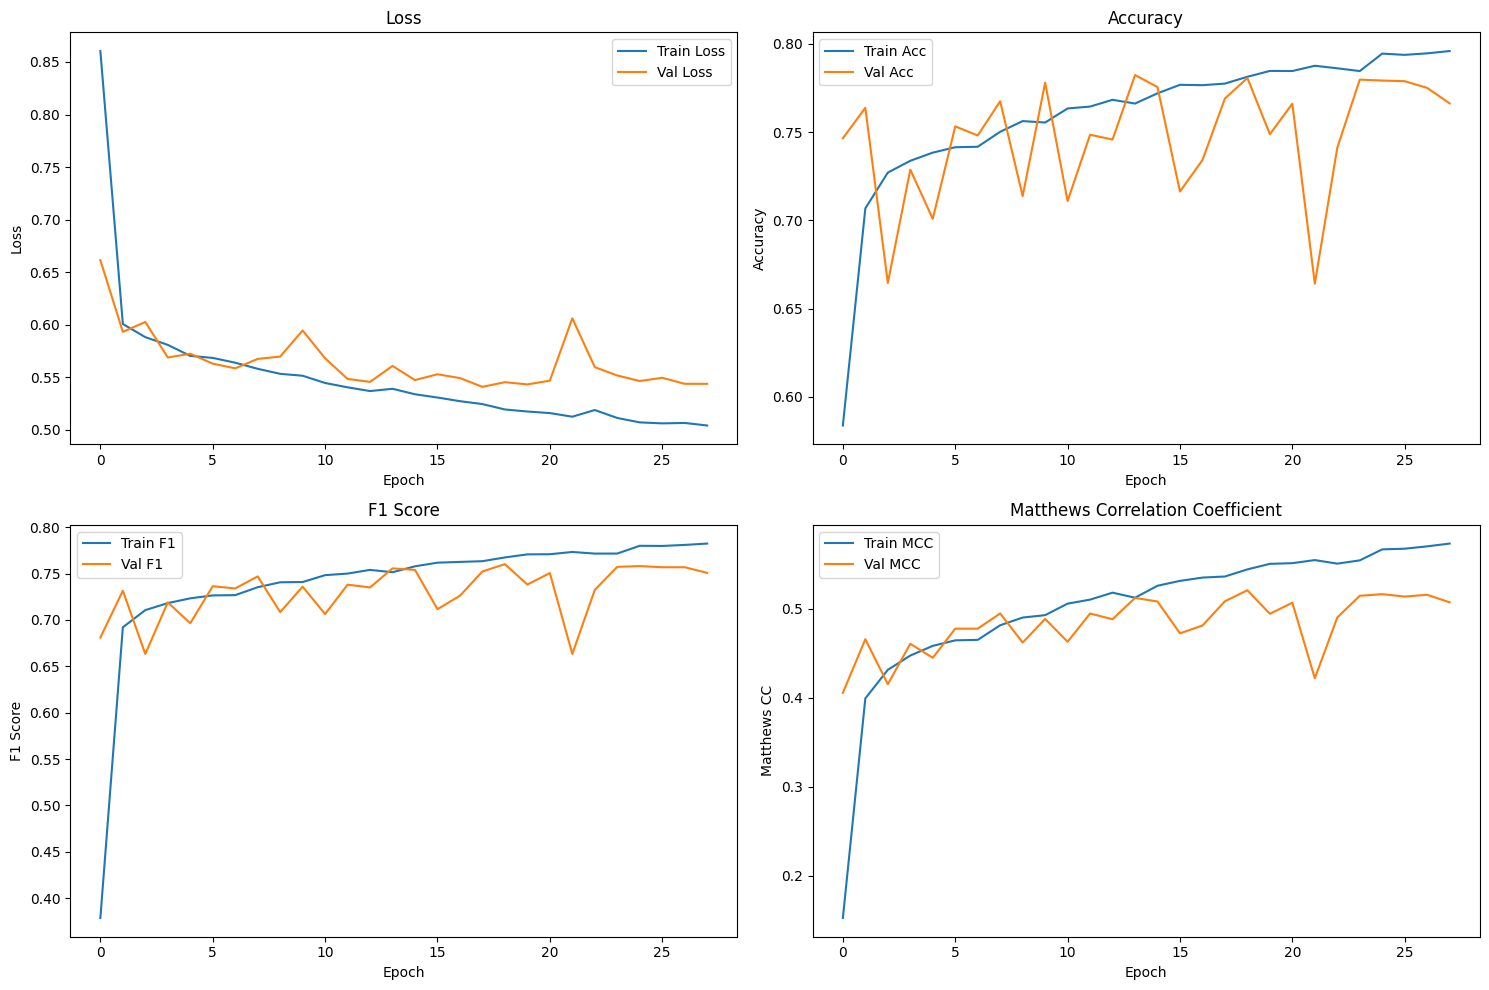

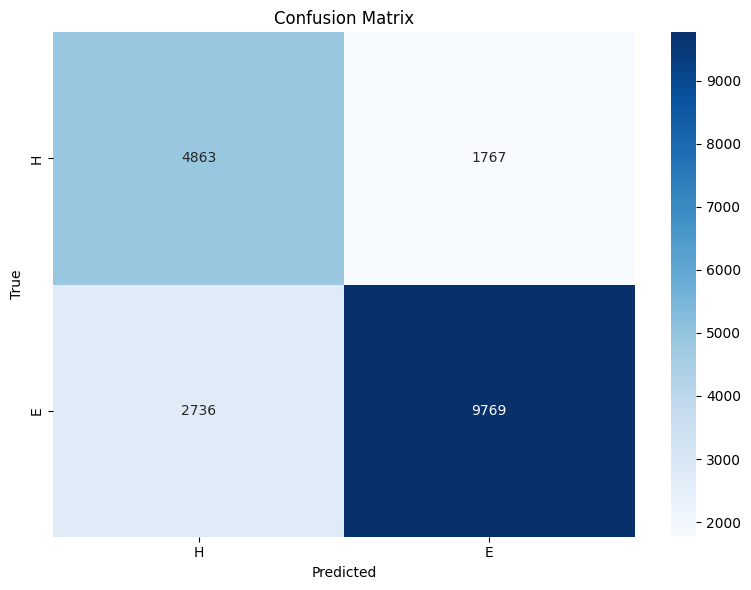

Per-class metrics:
H: Precision=0.6400, Recall=0.7335, F1=0.6835
E: Precision=0.8468, Recall=0.7812, F1=0.8127


In [29]:
# Load best model
model.load_state_dict(best_model_state)

# Evaluate model
print("Evaluating FASTA model...")
test_loss, test_acc, test_f1, test_mcc, cm = evaluate_model(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")
print(f"Test F1 Score: {test_f1:.4f}, Test MCC: {test_mcc:.4f}")

# Save model
os.makedirs('models', exist_ok=True)
torch.save({
    'model_state_dict': model.state_dict(),
    'test_acc': test_acc,
    'test_f1': test_f1,
    'test_mcc': test_mcc,
    'hyperparameters': {
        'input_dim': 21,
        'hidden_dim': hidden_dim,
        'num_layers': num_layers,
        'dropout': dropout
    }
}, 'models/fasta_model.pt')
print("Model saved to models/fasta_model.pt")

# Plot training history
plot_training_history(history)

# Plot confusion matrix
plot_confusion_matrix(cm)

# Store results for comparison
fasta_results = {
    'test_acc': test_acc,
    'test_f1': test_f1,
    'test_mcc': test_mcc
}

# Train and evaluate PSSM model

In [31]:
# Set random seed for reproducibility
set_seed(0)

# Set hyperparameters
batch_size = 32
num_epochs = 50
patience = 10
learning_rate = 1e-3
weight_decay = 1e-4
hidden_dim = 256
num_layers = 2
dropout = 0.3
label_smoothing = 0.1
pssm_tolerance = 1  # Tolerance for PSSM-DSSP length mismatch

# Prepare data with caching
train_loader, val_loader, test_loader = prepare_dataset(
    DATASET_PATH,
    input_type='pssm',
    batch_size=batch_size,
    pssm_tolerance=pssm_tolerance,
    cache_dir=cache_dir,
    use_cache=True,
    force_reload=False  # Set to True to force reprocessing of data
)



Loading cached processed data from /content/drive/MyDrive/dataset/cache/processed_data_pssm_seed0_tol1.pkl
Processed data loaded from /content/drive/MyDrive/dataset/cache/processed_data_pssm_seed0_tol1.pkl
Train: 840, Validation: 180, Test: 180


In [32]:
# Create model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Create model (input_dim=20 for PSSM)
model = PSSPModel(input_dim=20, hidden_dim=hidden_dim, output_dim=3, num_layers=num_layers, dropout=dropout)
model.to(device)

# Calculate class weights for imbalanced dataset
class_weights = None
try:
    # Extract all labels from the training set
    all_train_labels = []
    for _, labels, _ in train_loader:
        all_train_labels.extend(labels.view(-1).tolist())

    # Calculate class weights
    class_weights = calculate_class_weights(all_train_labels)
    class_weights = class_weights.to(device)
    print(f"Class weights: {class_weights}")
except Exception as e:
    print(f"Error calculating class weights: {e}")
    print("Using uniform class weights")

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss(weight=class_weights, ignore_index=0, label_smoothing=label_smoothing)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

# Train model
print("Training PSSM model...")
history, best_model_state = train_model(
    model, train_loader, val_loader, criterion, optimizer, device,
    num_epochs=num_epochs, patience=patience, scheduler=scheduler
)



Using device: cuda
Class weights: tensor([0.4242, 4.5654, 2.3615], device='cuda:0')
Training PSSM model...
Epoch: 1/50, Batch: 10/27, Loss: 0.6588
Epoch: 1/50, Batch: 20/27, Loss: 0.5640
Epoch: 1/50
Train Loss: 0.7206, Train Acc: 0.6583, Train F1: 0.4369, Train MCC: 0.3292
Val Loss: 0.5871, Val Acc: 0.7877, Val F1: 0.7616, Val MCC: 0.5242
Epoch: 2/50, Batch: 10/27, Loss: 0.5377
Epoch: 2/50, Batch: 20/27, Loss: 0.5355
Epoch: 2/50
Train Loss: 0.5468, Train Acc: 0.7633, Train F1: 0.7488, Train MCC: 0.5075
Val Loss: 0.5866, Val Acc: 0.8082, Val F1: 0.7752, Val MCC: 0.5625
Epoch: 3/50, Batch: 10/27, Loss: 0.5418
Epoch: 3/50, Batch: 20/27, Loss: 0.5233
Epoch: 3/50
Train Loss: 0.5315, Train Acc: 0.7805, Train F1: 0.7645, Train MCC: 0.5348
Val Loss: 0.6299, Val Acc: 0.7897, Val F1: 0.7447, Val MCC: 0.5163
Epoch: 4/50, Batch: 10/27, Loss: 0.5082
Epoch: 4/50, Batch: 20/27, Loss: 0.5093
Epoch: 4/50
Train Loss: 0.5197, Train Acc: 0.7880, Train F1: 0.7725, Train MCC: 0.5507
Val Loss: 0.5097, Val Ac

Evaluating PSSM model...
Test Loss: 0.4922, Test Accuracy: 0.8137
Test F1 Score: 0.8001, Test MCC: 0.6042
Model saved to models/pssm_model.pt


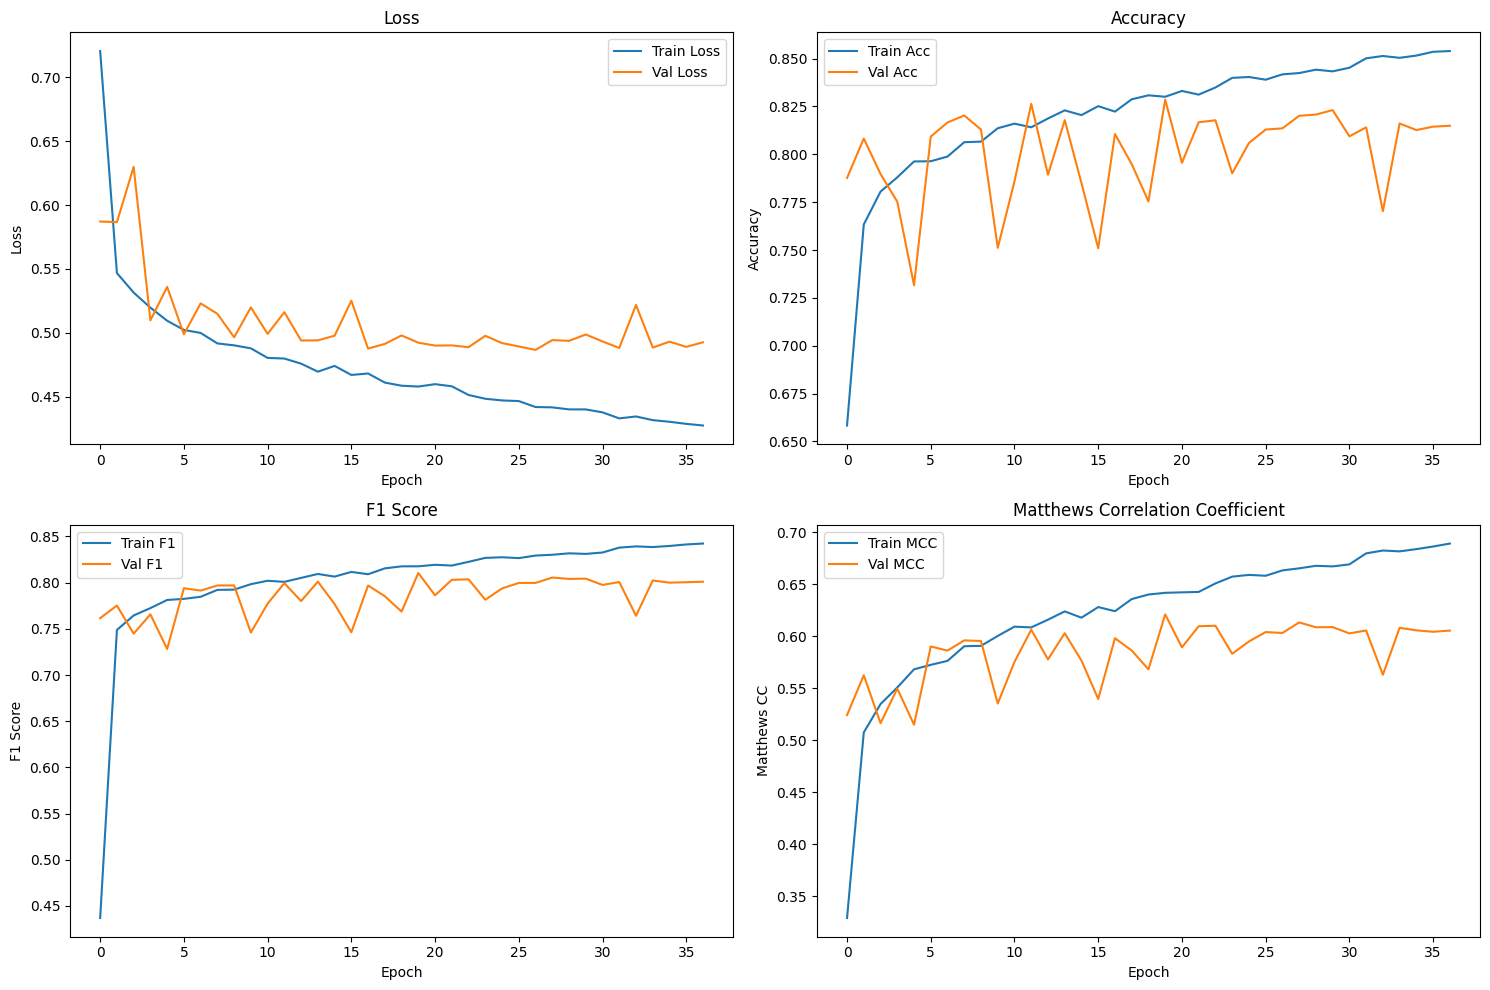

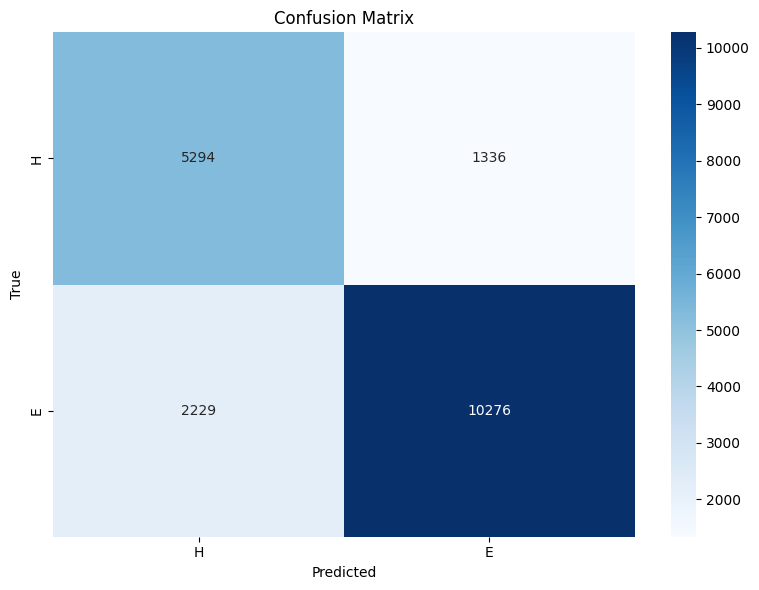

Per-class metrics:
H: Precision=0.7037, Recall=0.7985, F1=0.7481
E: Precision=0.8849, Recall=0.8218, F1=0.8522


In [33]:
# Load best model
model.load_state_dict(best_model_state)

# Evaluate model
print("Evaluating PSSM model...")
test_loss, test_acc, test_f1, test_mcc, cm = evaluate_model(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")
print(f"Test F1 Score: {test_f1:.4f}, Test MCC: {test_mcc:.4f}")

# Save model
os.makedirs('models', exist_ok=True)
torch.save({
    'model_state_dict': model.state_dict(),
    'test_acc': test_acc,
    'test_f1': test_f1,
    'test_mcc': test_mcc,
    'hyperparameters': {
        'input_dim': 20,
        'hidden_dim': hidden_dim,
        'num_layers': num_layers,
        'dropout': dropout
    }
}, 'models/pssm_model.pt')
print("Model saved to models/pssm_model.pt")

# Plot training history
plot_training_history(history)

# Plot confusion matrix
plot_confusion_matrix(cm)

# Store results for comparison
pssm_results = {
    'test_acc': test_acc,
    'test_f1': test_f1,
    'test_mcc': test_mcc
}

# Train and evaluate Combined model (FASTA + PSSM)

In [24]:
# Set random seed for reproducibility
set_seed(0)

# Set hyperparameters
batch_size = 32
num_epochs = 50
patience = 10
learning_rate = 1e-3
weight_decay = 1e-4
hidden_dim = 256
num_layers = 2
dropout = 0.3
label_smoothing = 0.1
pssm_tolerance = 1  # Tolerance for PSSM-DSSP length mismatch

# Prepare data with caching
train_loader, val_loader, test_loader = prepare_dataset(
    DATASET_PATH,
    input_type='combined',
    batch_size=batch_size,
    pssm_tolerance=pssm_tolerance,
    cache_dir=cache_dir,
    use_cache=True,
    force_reload=False  # Set to True to force reprocessing of data
)

Loading cached processed data from /content/drive/MyDrive/dataset/cache/processed_data_combined_seed0_tol1.pkl
Processed data loaded from /content/drive/MyDrive/dataset/cache/processed_data_combined_seed0_tol1.pkl
Train: 840, Validation: 180, Test: 180


In [25]:
# Create model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Create model (input_dim=41 for combined FASTA+PSSM: 21 for FASTA + 20 for PSSM)
model = PSSPModel(input_dim=41, hidden_dim=hidden_dim, output_dim=3, num_layers=num_layers, dropout=dropout)
model.to(device)

# Calculate class weights for imbalanced dataset
class_weights = None
try:
    # Extract all labels from the training set
    all_train_labels = []
    for _, labels, _ in train_loader:
        all_train_labels.extend(labels.view(-1).tolist())

    # Calculate class weights
    class_weights = calculate_class_weights(all_train_labels)
    class_weights = class_weights.to(device)
    print(f"Class weights: {class_weights}")
except Exception as e:
    print(f"Error calculating class weights: {e}")
    print("Using uniform class weights")

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss(weight=class_weights, ignore_index=0, label_smoothing=label_smoothing)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

# Train model
print("Training Combined model...")
history, best_model_state = train_model(
    model, train_loader, val_loader, criterion, optimizer, device,
    num_epochs=num_epochs, patience=patience, scheduler=scheduler
)



Using device: cuda
Class weights: tensor([0.4232, 4.6062, 2.3827], device='cuda:0')
Training Combined model...
Epoch: 1/50, Batch: 10/27, Loss: 0.7334
Epoch: 1/50, Batch: 20/27, Loss: 0.5664
Epoch: 1/50
Train Loss: 0.7820, Train Acc: 0.6365, Train F1: 0.4200, Train MCC: 0.2818
Val Loss: 0.6061, Val Acc: 0.7206, Val F1: 0.7146, Val MCC: 0.4693
Epoch: 2/50, Batch: 10/27, Loss: 0.5709
Epoch: 2/50, Batch: 20/27, Loss: 0.5530
Epoch: 2/50
Train Loss: 0.5420, Train Acc: 0.7696, Train F1: 0.7549, Train MCC: 0.5190
Val Loss: 0.5194, Val Acc: 0.7832, Val F1: 0.7705, Val MCC: 0.5496
Epoch: 3/50, Batch: 10/27, Loss: 0.5831
Epoch: 3/50, Batch: 20/27, Loss: 0.5052
Epoch: 3/50
Train Loss: 0.5260, Train Acc: 0.7856, Train F1: 0.7700, Train MCC: 0.5457
Val Loss: 0.5324, Val Acc: 0.7343, Val F1: 0.7304, Val MCC: 0.5141
Epoch: 4/50, Batch: 10/27, Loss: 0.5316
Epoch: 4/50, Batch: 20/27, Loss: 0.5528
Epoch: 4/50
Train Loss: 0.5111, Train Acc: 0.7926, Train F1: 0.7781, Train MCC: 0.5633
Val Loss: 0.5241, Va

Evaluating Combined model...
Test Loss: 0.4976, Test Accuracy: 0.8062
Test F1 Score: 0.7935, Test MCC: 0.5933
Model saved to models/combined_model.pt


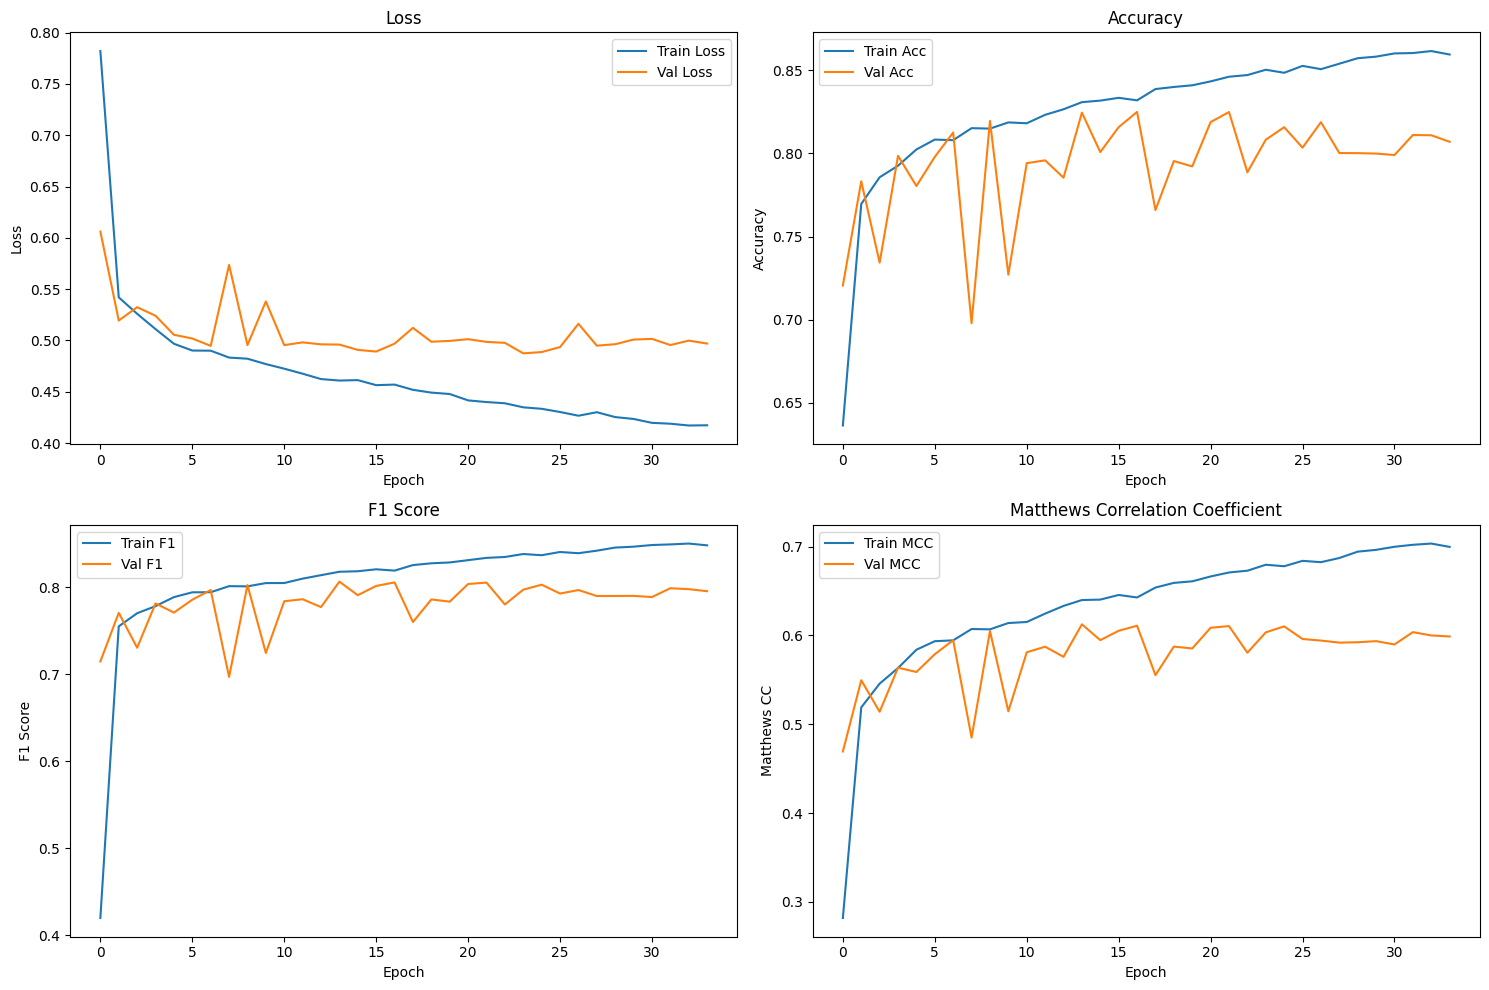

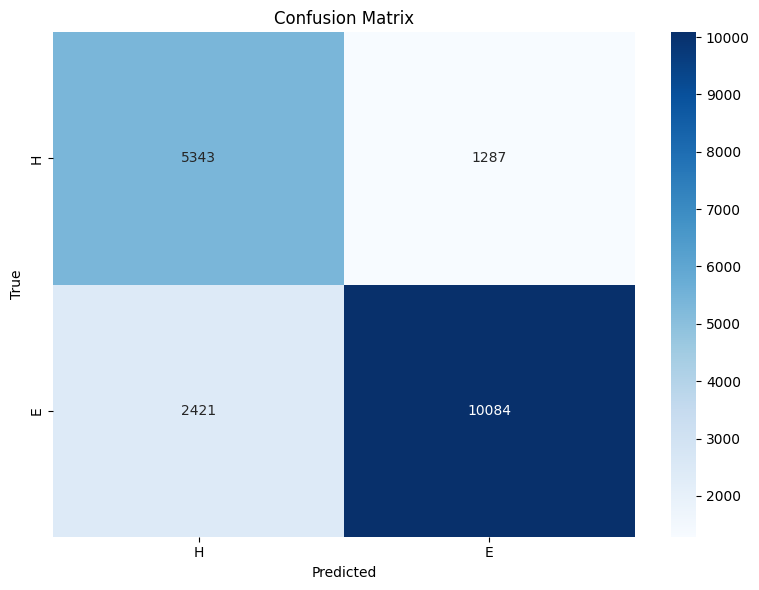

Per-class metrics:
H: Precision=0.6882, Recall=0.8059, F1=0.7424
E: Precision=0.8868, Recall=0.8064, F1=0.8447


In [26]:
# Load best model
model.load_state_dict(best_model_state)

# Evaluate model
print("Evaluating Combined model...")
test_loss, test_acc, test_f1, test_mcc, cm = evaluate_model(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")
print(f"Test F1 Score: {test_f1:.4f}, Test MCC: {test_mcc:.4f}")

# Save model
os.makedirs('models', exist_ok=True)
torch.save({
    'model_state_dict': model.state_dict(),
    'test_acc': test_acc,
    'test_f1': test_f1,
    'test_mcc': test_mcc,
    'hyperparameters': {
        'input_dim': 41,
        'hidden_dim': hidden_dim,
        'num_layers': num_layers,
        'dropout': dropout
    }
}, 'models/combined_model.pt')
print("Model saved to models/combined_model.pt")

# Plot training history
plot_training_history(history)

# Plot confusion matrix
plot_confusion_matrix(cm)

# Store results for comparison
combined_results = {
    'test_acc': test_acc,
    'test_f1': test_f1,
    'test_mcc': test_mcc
}

# Compare models



Model Comparison:
FASTA model: Acc=0.7647, F1=0.7481, MCC=0.5005
PSSM model: Acc=0.8137, F1=0.8001, MCC=0.6042
Combined model: Acc=0.8062, F1=0.7935, MCC=0.5933


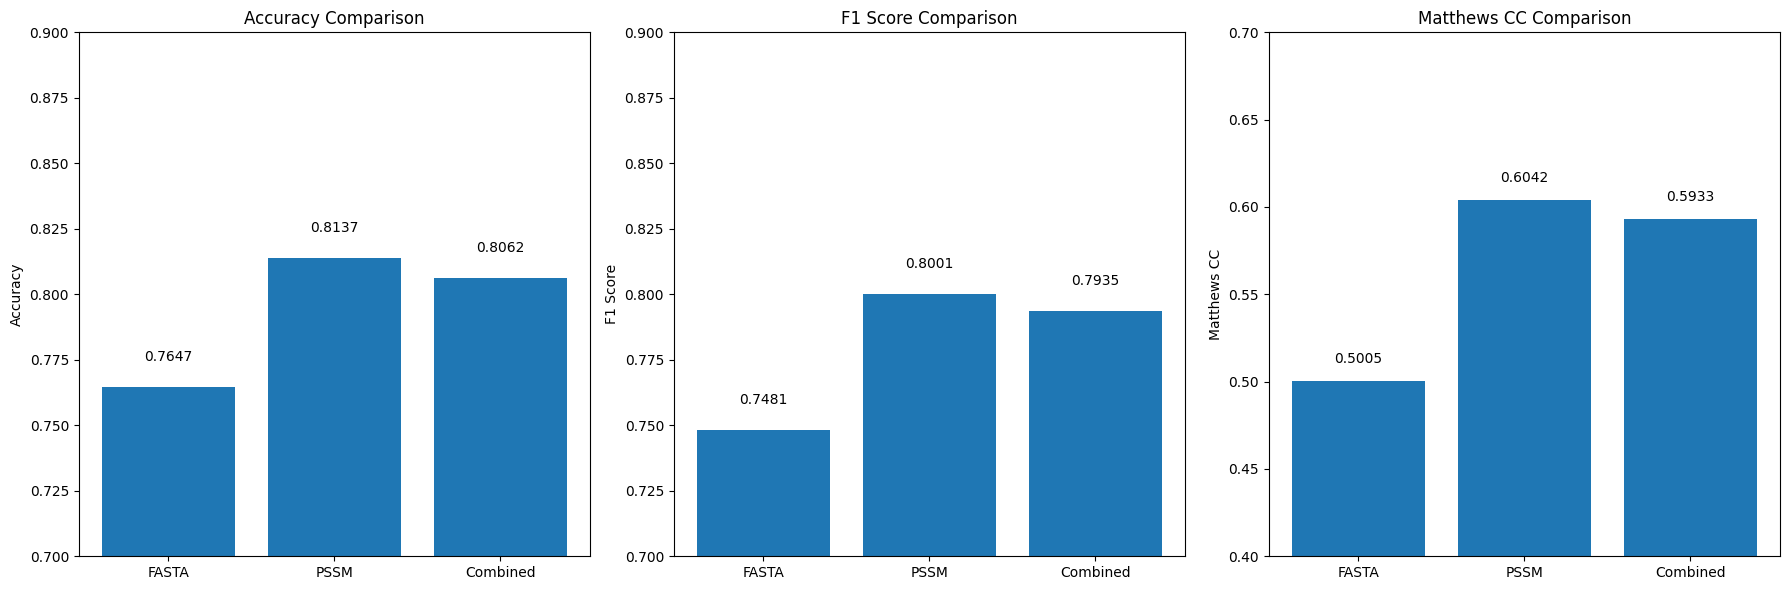

In [36]:
# Import required libraries
import matplotlib.pyplot as plt
import numpy as np

# Define variables to store accuracy values
try:
    fasta_acc = fasta_results['test_acc']
    fasta_f1 = fasta_results['test_f1']
    fasta_mcc = fasta_results['test_mcc']
except:
    fasta_acc = None
    fasta_f1 = None
    fasta_mcc = None

try:
    pssm_acc = pssm_results['test_acc']
    pssm_f1 = pssm_results['test_f1']
    pssm_mcc = pssm_results['test_mcc']
except:
    pssm_acc = None
    pssm_f1 = None
    pssm_mcc = None

try:
    combined_acc = combined_results['test_acc']
    combined_f1 = combined_results['test_f1']
    combined_mcc = combined_results['test_mcc']
except:
    combined_acc = None
    combined_f1 = None
    combined_mcc = None

# Compare models
print("\nModel Comparison:")
if fasta_acc is not None:
    print(f"FASTA model: Acc={fasta_acc:.4f}, F1={fasta_f1:.4f}, MCC={fasta_mcc:.4f}")
if pssm_acc is not None:
    print(f"PSSM model: Acc={pssm_acc:.4f}, F1={pssm_f1:.4f}, MCC={pssm_mcc:.4f}")
if combined_acc is not None:
    print(f"Combined model: Acc={combined_acc:.4f}, F1={combined_f1:.4f}, MCC={combined_mcc:.4f}")

# Plot comparison if at least two models are available
models_available = sum(x is not None for x in [fasta_acc, pssm_acc, combined_acc])
if models_available >= 2:
    # Create figure with 3 subplots
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Prepare data
    model_names = []
    acc_values = []
    f1_values = []
    mcc_values = []

    if fasta_acc is not None:
        model_names.append('FASTA')
        acc_values.append(fasta_acc)
        f1_values.append(fasta_f1)
        mcc_values.append(fasta_mcc)

    if pssm_acc is not None:
        model_names.append('PSSM')
        acc_values.append(pssm_acc)
        f1_values.append(pssm_f1)
        mcc_values.append(pssm_mcc)

    if combined_acc is not None:
        model_names.append('Combined')
        acc_values.append(combined_acc)
        f1_values.append(combined_f1)
        mcc_values.append(combined_mcc)

    # Plot accuracy
    axes[0].bar(model_names, acc_values)
    axes[0].set_ylabel('Accuracy')
    axes[0].set_title('Accuracy Comparison')
    axes[0].set_ylim([0.7, 0.9])  # Adjust as needed
    for i, v in enumerate(acc_values):
        axes[0].text(i, v + 0.01, f"{v:.4f}", ha='center')

    # Plot F1 score
    axes[1].bar(model_names, f1_values)
    axes[1].set_ylabel('F1 Score')
    axes[1].set_title('F1 Score Comparison')
    axes[1].set_ylim([0.7, 0.9])  # Adjust as needed
    for i, v in enumerate(f1_values):
        axes[1].text(i, v + 0.01, f"{v:.4f}", ha='center')

    # Plot MCC
    axes[2].bar(model_names, mcc_values)
    axes[2].set_ylabel('Matthews CC')
    axes[2].set_title('Matthews CC Comparison')
    axes[2].set_ylim([0.4, 0.7])  # Adjust as needed
    for i, v in enumerate(mcc_values):
        axes[2].text(i, v + 0.01, f"{v:.4f}", ha='center')

    plt.tight_layout()
    plt.show()
else:
    print("Not enough models to compare. Train at least two models first.")

# Prediction on new sequences

In [41]:
# Function to predict secondary structure for a new sequence
def predict_secondary_structure(sequence, model_path, device, input_type='fasta', pssm_file=None):
    """
    Predict secondary structure for a new protein sequence
    Args:
        sequence: Amino acid sequence (string)
        model_path: Path to the saved model
        device: Device to run the model on
        input_type: 'fasta', 'pssm', or 'combined'
        pssm_file: Path to PSSM file (required for 'pssm' or 'combined' input types)
    Returns:
        Predicted secondary structure (string)
    """
    # Load model
    # Set weights_only=False to handle PyTorch 2.6 compatibility
    checkpoint = torch.load(model_path, weights_only=False)
    hyperparams = checkpoint['hyperparameters']

    model = PSSPModel(
        input_dim=hyperparams['input_dim'],
        hidden_dim=hyperparams['hidden_dim'],
        output_dim=3,
        num_layers=hyperparams['num_layers'],
        dropout=hyperparams['dropout']
    )
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    model.eval()

    # Prepare input
    if input_type == 'fasta':
        # One-hot encode the sequence
        aa_to_idx = {
            'A': 0, 'C': 1, 'D': 2, 'E': 3, 'F': 4, 'G': 5, 'H': 6, 'I': 7,
            'K': 8, 'L': 9, 'M': 10, 'N': 11, 'P': 12, 'Q': 13, 'R': 14,
            'S': 15, 'T': 16, 'V': 17, 'W': 18, 'Y': 19, 'X': 20
        }
        encoded = np.zeros((len(sequence), 21))
        for i, aa in enumerate(sequence):
            if aa in aa_to_idx:
                encoded[i, aa_to_idx[aa]] = 1
            else:
                encoded[i, aa_to_idx['X']] = 1  # Unknown amino acid

    elif input_type == 'pssm':
        if pssm_file is None:
            raise ValueError("PSSM file is required for 'pssm' input type")

        # Load PSSM
        pssm = pd.read_csv(pssm_file).values

        # Min-max normalize PSSM
        encoded = pssm.copy()
        row_min = encoded.min(axis=1, keepdims=True)
        row_max = encoded.max(axis=1, keepdims=True)
        row_range = row_max - row_min
        row_range[row_range == 0] = 1  # Avoid division by zero
        encoded = (encoded - row_min) / row_range

    else:  # combined
        if pssm_file is None:
            raise ValueError("PSSM file is required for 'combined' input type")

        # One-hot encode FASTA
        aa_to_idx = {
            'A': 0, 'C': 1, 'D': 2, 'E': 3, 'F': 4, 'G': 5, 'H': 6, 'I': 7,
            'K': 8, 'L': 9, 'M': 10, 'N': 11, 'P': 12, 'Q': 13, 'R': 14,
            'S': 15, 'T': 16, 'V': 17, 'W': 18, 'Y': 19, 'X': 20
        }
        fasta_encoded = np.zeros((len(sequence), 21))
        for i, aa in enumerate(sequence):
            if aa in aa_to_idx:
                fasta_encoded[i, aa_to_idx[aa]] = 1
            else:
                fasta_encoded[i, aa_to_idx['X']] = 1

        # Load and normalize PSSM
        pssm = pd.read_csv(pssm_file).values
        pssm_encoded = pssm.copy()
        row_min = pssm_encoded.min(axis=1, keepdims=True)
        row_max = pssm_encoded.max(axis=1, keepdims=True)
        row_range = row_max - row_min
        row_range[row_range == 0] = 1
        pssm_encoded = (pssm_encoded - row_min) / row_range

        # Ensure PSSM and FASTA have the same length
        min_len = min(fasta_encoded.shape[0], pssm_encoded.shape[0])
        fasta_encoded = fasta_encoded[:min_len]
        pssm_encoded = pssm_encoded[:min_len]

        # Concatenate FASTA and PSSM
        encoded = np.concatenate([fasta_encoded, pssm_encoded], axis=1)

    # Convert to tensor
    encoded_tensor = torch.FloatTensor(encoded).unsqueeze(0)  # Add batch dimension
    lengths = torch.LongTensor([encoded_tensor.size(1)])  # Sequence length

    # Predict
    with torch.no_grad():
        encoded_tensor = encoded_tensor.to(device)
        lengths = lengths.to(device)
        output = model(encoded_tensor, lengths)
        _, predicted = torch.max(output.squeeze(0), 1)

    # Convert to secondary structure string
    idx_to_ss = {0: 'H', 1: 'E', 2: 'C'}
    ss_prediction = ''.join([idx_to_ss[idx.item()] for idx in predicted])

    return ss_prediction

In [42]:
# Example usage
def visualize_prediction(sequence, ss_prediction):
    """
    Visualize the predicted secondary structure
    Args:
        sequence: Amino acid sequence
        ss_prediction: Predicted secondary structure
    """
    plt.figure(figsize=(15, 3))

    # Plot sequence
    for i, aa in enumerate(sequence):
        plt.text(i, 0.5, aa, ha='center', va='center', fontsize=8)

    # Plot secondary structure with colors
    for i, ss in enumerate(ss_prediction):
        if ss == 'H':
            color = 'red'
        elif ss == 'E':
            color = 'blue'
        else:  # 'C'
            color = 'green'
        plt.text(i, 0, ss, ha='center', va='center', fontsize=8, color=color, weight='bold')

    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='red', label='Helix (H)'),
        Patch(facecolor='blue', label='Strand (E)'),
        Patch(facecolor='green', label='Coil (C)')
    ]
    plt.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)

    plt.xlim(-1, len(sequence))
    plt.ylim(-0.5, 1)
    plt.axis('off')
    plt.title('Protein Secondary Structure Prediction')
    plt.tight_layout()
    plt.show()

Available models: ['FASTA', 'PSSM', 'Combined']

FASTA model prediction:
Sequence length: 154
Prediction length: 154
Helix (H): 0 (0.0%)
Strand (E): 29 (18.8%)
Coil (C): 125 (81.2%)


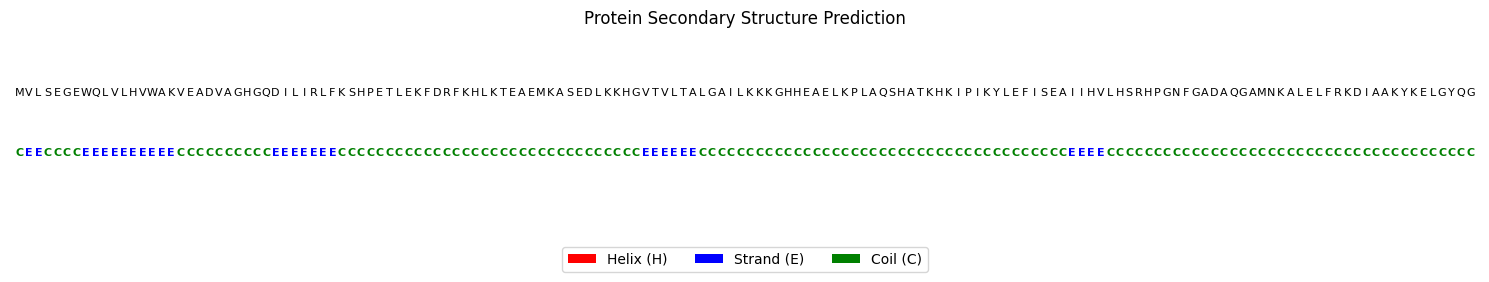

Skipping PSSM model (requires PSSM file)
Skipping Combined model (requires PSSM file)


In [45]:
# Check if models exist
fasta_model_path = 'models/fasta_model.pt'
pssm_model_path = 'models/pssm_model.pt'
combined_model_path = 'models/combined_model.pt'

models_available = []
if os.path.exists(fasta_model_path):
    models_available.append(('FASTA', fasta_model_path))
if os.path.exists(pssm_model_path):
    models_available.append(('PSSM', pssm_model_path))
if os.path.exists(combined_model_path):
    models_available.append(('Combined', combined_model_path))

if models_available:
    print(f"Available models: {[model[0] for model in models_available]}")

    # Example sequence (replace with your own)
    example_sequence = "MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDRFKHLKTEAEMKASEDLKKHGVTVLTALGAILKKKGHHEAELKPLAQSHATKHKIPIKYLEFISEAIIHVLHSRHPGNFGADAQGAMNKALELFRKDIAAKYKELGYQG"

    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Make predictions with all available models
    predictions = {}
    for model_name, model_path in models_available:
        try:
            if model_name == 'FASTA':
                ss_prediction = predict_secondary_structure(
                    example_sequence, model_path, device, input_type='fasta'
                )
            elif model_name == 'PSSM':
                print(f"Skipping {model_name} model (requires PSSM file)")
                continue
            elif model_name == 'Combined':
                print(f"Skipping {model_name} model (requires PSSM file)")
                continue

            predictions[model_name] = ss_prediction

            # Print results
            print(f"\n{model_name} model prediction:")
            print(f"Sequence length: {len(example_sequence)}")
            print(f"Prediction length: {len(ss_prediction)}")

            # Calculate secondary structure composition
            h_count = ss_prediction.count('H')
            e_count = ss_prediction.count('E')
            c_count = ss_prediction.count('C')
            total = len(ss_prediction)

            print(f"Helix (H): {h_count} ({h_count/total*100:.1f}%)")
            print(f"Strand (E): {e_count} ({e_count/total*100:.1f}%)")
            print(f"Coil (C): {c_count} ({c_count/total*100:.1f}%)")

            # Visualize prediction
            visualize_prediction(example_sequence, ss_prediction)

        except Exception as e:
            print(f"Error making prediction with {model_name} model: {e}")
else:
    print("No models found. Train at least one model first.")

# To use with PSSM or Combined models, you need to provide a PSSM file:
# ss_prediction = predict_secondary_structure(
#     example_sequence,
#     'models/combined_model.pt',
#     device,
#     input_type='combined',
#     pssm_file='path/to/pssm.csv'
# )